In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os

%matplotlib inline
plt.rcParams['figure.figsize'] = (9,5)

print("Files in working directory:", os.listdir())

Files in working directory: ['.config', 'drive', 'sample_data']


In [9]:
# Load the dataset (your uploaded file name)
df = pd.read_csv("/content/drive/MyDrive/Dataset/Dataset/diabetes_.csv")

print("Shape:", df.shape)
display(df.head())
print(df.isnull().sum())

Shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


In [31]:
#Cell 3 — Missing Value Handling
data = df.copy()
missing_pct = data.isnull().sum() / len(data) * 100

for col in data.columns:
    pct = missing_pct[col]
    if pct > 10:
        if pd.api.types.is_numeric_dtype(data[col]):
            data[col].fillna(data[col].mean(), inplace=True)
        else:
            data[col].fillna(data[col].mode().iloc[0], inplace=True)
    else:
        data.dropna(subset=[col], inplace=True)

print("After cleaning:", data.shape)
print(data.isnull().sum())


After cleaning: (768, 9)
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


In [11]:
# Your dataset uses Outcome as target. If not, last column is used.
if "Outcome" in data.columns:
    target = "Outcome"
else:
    target = data.columns[-1]

X = data.drop(columns=[target]).values
y = data[target].values.astype(int)

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Unique labels:", np.unique(y))


X shape: (768, 8)
y shape: (768,)
Unique labels: [0 1]


In [29]:
#Cell 5 — Train Test Split (Scratch)
def train_test_split_scratch(X, y, test_size=0.3, seed=42):
    np.random.seed(seed)
    indices = np.arange(len(X))
    np.random.shuffle(indices)

    test_n = int(len(X) * test_size)
    test_idx = indices[:test_n]
    train_idx = indices[test_n:]

    return X[train_idx], X[test_idx], y[train_idx], y[test_idx]

X_train, X_test, y_train, y_test = train_test_split_scratch(X, y, test_size=0.3)

print(X_train.shape, X_test.shape)


(538, 8) (230, 8)


In [30]:
#Cell 6 — Euclidean Distance (Vectorized)
def euclidean_distances(X1, X2):
    X1 = X1.astype(float)
    X2 = X2.astype(float)

    X1_sq = np.sum(X1**2, axis=1).reshape(-1,1)
    X2_sq = np.sum(X2**2, axis=1).reshape(1,-1)
    cross = X1 @ X2.T

    dists = X1_sq + X2_sq - 2*cross
    dists = np.maximum(dists, 0)

    return np.sqrt(dists)


In [28]:
#Cell 7 — KNN Predict (Fast Vectorized)
def knn_predict(X_test, X_train, y_train, k=3):
    dists = euclidean_distances(X_test, X_train)
    nearest_idx = np.argpartition(dists, k-1, axis=1)[:, :k]

    predictions = []
    for row in nearest_idx:
        labels = y_train[row]
        counts = np.bincount(labels)
        predictions.append(np.argmax(counts))

    return np.array(predictions)


In [27]:
#Cell 8 — Accuracy Function
def compute_accuracy(y_true, y_pred):
    return (np.sum(y_true == y_pred) / len(y_true)) * 100


In [17]:
#Cell 9 — Evaluate KNN on Original Data
k = 3

start = time.time()
preds_original = knn_predict(X_test, X_train, y_train, k)
t_original = time.time() - start

acc_original = compute_accuracy(y_test, preds_original)

print(f"Original Data → k={k}, Accuracy={acc_original:.2f}%, Time={t_original:.4f} sec")


Original Data → k=3, Accuracy=67.39%, Time=0.0105 sec


In [20]:
#Cell 10 — Scaling (Standardization)
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)
std[std == 0] = 1

X_train_scaled = (X_train - mean) / std
X_test_scaled = (X_test - mean) / std


In [22]:
#Cell 11 — Evaluate KNN on Scaled Data
start = time.time()
preds_scaled = knn_predict(X_test_scaled, X_train_scaled, y_train, k)
t_scaled = time.time() - start

acc_scaled = compute_accuracy(y_test, preds_scaled)

print(f"Scaled Data → k={k}, Accuracy={acc_scaled:.2f}%, Time={t_scaled:.4f} sec")


Scaled Data → k=3, Accuracy=70.87%, Time=0.0103 sec


In [24]:
#Cell 12 — Experiment: k = 1 to 15
k_values = range(1, 16)

acc_orig = []
acc_scaled = []
time_orig = []
time_scaled = []

for k in k_values:
    # original
    t0 = time.time()
    p1 = knn_predict(X_test, X_train, y_train, k)
    t1 = time.time()

    # scaled
    t2 = time.time()
    p2 = knn_predict(X_test_scaled, X_train_scaled, y_train, k)
    t3 = time.time()

    acc_orig.append(compute_accuracy(y_test, p1))
    acc_scaled.append(compute_accuracy(y_test, p2))

    time_orig.append(t1 - t0)
    time_scaled.append(t3 - t2)

results = pd.DataFrame({
    "k": list(k_values),
    "accuracy_original": acc_orig,
    "accuracy_scaled": acc_scaled,
    "time_original": time_orig,
    "time_scaled": time_scaled
})

results


,k,accuracy_original,accuracy_scaled,time_original,time_scaled
0,1,68.695652,63.478261,0.007793,0.006523
1,2,72.608696,66.086957,0.005508,0.005592
2,3,67.391304,70.869565,0.005642,0.005606
3,4,72.173913,68.695652,0.005284,0.005593
4,5,68.695652,70.000000,0.005397,0.005898
5,6,70.000000,69.130435,0.005748,0.005618
6,7,69.130435,69.565217,0.005480,0.005934
7,8,71.304348,68.695652,0.005538,0.005678
8,9,70.000000,69.565217,0.005816,0.006315
9,10,71.739130,69.565217,0.005490,0.005784


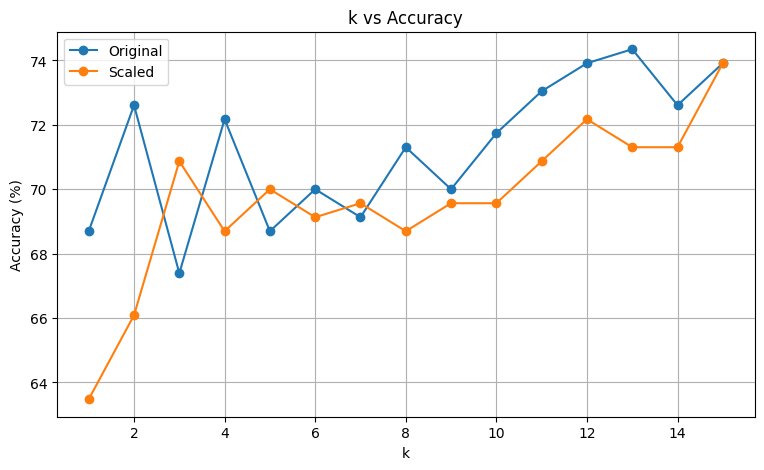

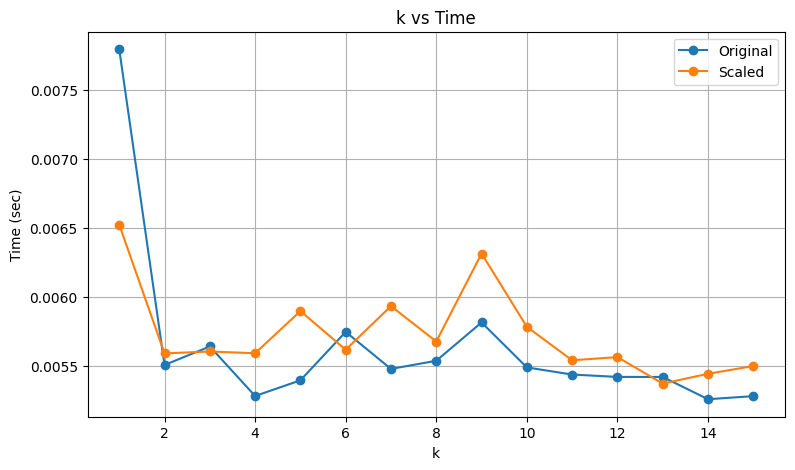

In [26]:
#Cell 13 — Plots
plt.plot(results["k"], results["accuracy_original"], marker='o', label="Original")
plt.plot(results["k"], results["accuracy_scaled"], marker='o', label="Scaled")
plt.xlabel("k")
plt.ylabel("Accuracy (%)")
plt.title("k vs Accuracy")
plt.grid(True)
plt.legend()
plt.show()

plt.plot(results["k"], results["time_original"], marker='o', label="Original")
plt.plot(results["k"], results["time_scaled"], marker='o', label="Scaled")
plt.xlabel("k")
plt.ylabel("Time (sec)")
plt.title("k vs Time")
plt.grid(True)
plt.legend()
plt.show()
